In [1]:
%pip install tensorflow matplotlib scikit-learn pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
from tensorflow import keras
from keras import backend
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Subtract, Dense, Input
from keras.models import Model
import numpy as np
import requests
from ltr.data import CorpusApi

In [41]:
INPUT_DIM = 24
h_1_dim = 128
h_2_dim = h_1_dim // 2
h_3_dim = h_2_dim // 2

# Model.
h_1 = Dense(h_1_dim, activation = "relu")
h_2 = Dense(h_2_dim, activation = "relu")
h_3 = Dense(h_3_dim, activation = "relu")
s = Dense(1)

# Relevant document score.
rel_doc = Input(shape = (INPUT_DIM, ), dtype = "float32")
h_1_rel = h_1(rel_doc)
h_2_rel = h_2(h_1_rel)
h_3_rel = h_3(h_2_rel)
rel_score = s(h_3_rel)

# Irrelevant document score.
irr_doc = Input(shape = (INPUT_DIM, ), dtype = "float32")
h_1_irr = h_1(irr_doc)
h_2_irr = h_2(h_1_irr)
h_3_irr = h_3(h_2_irr)
irr_score = s(h_3_irr)

# Subtract scores.
diff = Subtract()([rel_score, irr_score])

# Pass difference through sigmoid function.
prob = Activation("sigmoid")(diff)

# Build model.
model = Model(inputs = [rel_doc, irr_doc], outputs = prob)
model.compile(optimizer = "adadelta", loss = "binary_crossentropy", metrics=['accuracy'])

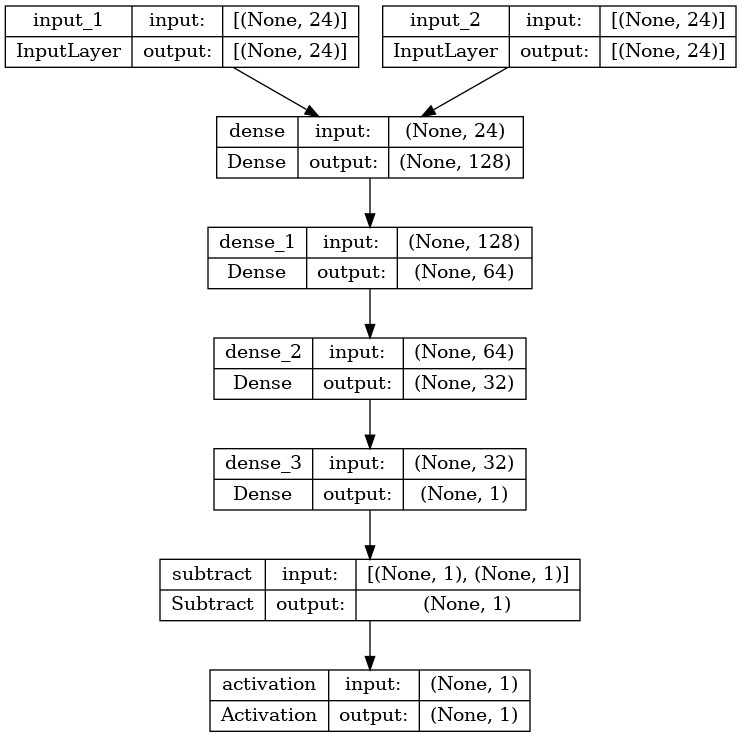

In [4]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
from os import listdir
from os.path import isfile, join
def getJudgmentsBatchFileByFile():
    """
    Returns a generator function that returns all the judgment batches files from the directory
    """
    files = []
   
    files = [join('./loggedFeatures', file) for file in listdir('./loggedFeatures') if isfile(join('./loggedFeatures', file))]
    for file in files:
        yield file

In [6]:
import csv
judgments = []
for file in getJudgmentsBatchFileByFile():
  with open(file,'r') as f:
    reader = csv.reader(f, delimiter=' ')
    for row in reader:
      data = []
      for element in row:
        data.append(element.replace(',', ''))
      judgments.append(data)

In [7]:
judgments.sort(key = lambda judgments: judgments[1])
print(judgments[0])
print(judgments[1])
print(judgments[2])
print(judgments[3])

['0', '10000', 'msmarco_doc_05_72507775', '1.0', '2.0', '8.0', '8.0', '0.083333336', '0.16666667', '0.6666667', '0.6666667', '1.0', '2.4142137', '36.53677', '36.764153', '90.677284', '72.23833', '41.410515', '41.410515', '7.282527', '10.645987', '84.99544', '85.76555', '1.655931', '1.747792', '5.9285426', '6.021519']
['1', '10000', 'msmarco_doc_10_1691063043', '1.0', '8.0', '9.0', '9.0', '0.083333336', '0.6666667', '0.75', '0.75', '1.0', '11.69213', '55.452248', '56.990223', '90.677284', '72.23833', '41.410515', '41.410515', '7.7639008', '64.12446', '153.44191', '158.3429', '3.4576335', '13.961745', '14.04283', '14.179642']
['1', '1000005', 'msmarco_doc_19_673141443', '2.0', '2.0', '4.0', '4.0', '0.5', '0.5', '1.0', '1.0', '2.0', '2.828427', '18.934044', '19.41233', '27.758165', '22.795256', '13.165058', '13.165058', '17.45566', '22.153984', '77.66603', '79.93644', '9.476915', '9.96361', '7.746788', '7.7889223']
['0', '1000005', 'msmarco_doc_19_673231526', '1.0', '1.0', '2.0', '2.0', '

In [8]:
for j in judgments:
  del j[2]

print(judgments[0])
print(judgments[1])
print(judgments[2])
print(judgments[3])
print(judgments[4])
print(judgments[5])
print(judgments[6])
print(judgments[7])

['0', '10000', '1.0', '2.0', '8.0', '8.0', '0.083333336', '0.16666667', '0.6666667', '0.6666667', '1.0', '2.4142137', '36.53677', '36.764153', '90.677284', '72.23833', '41.410515', '41.410515', '7.282527', '10.645987', '84.99544', '85.76555', '1.655931', '1.747792', '5.9285426', '6.021519']
['1', '10000', '1.0', '8.0', '9.0', '9.0', '0.083333336', '0.6666667', '0.75', '0.75', '1.0', '11.69213', '55.452248', '56.990223', '90.677284', '72.23833', '41.410515', '41.410515', '7.7639008', '64.12446', '153.44191', '158.3429', '3.4576335', '13.961745', '14.04283', '14.179642']
['1', '1000005', '2.0', '2.0', '4.0', '4.0', '0.5', '0.5', '1.0', '1.0', '2.0', '2.828427', '18.934044', '19.41233', '27.758165', '22.795256', '13.165058', '13.165058', '17.45566', '22.153984', '77.66603', '79.93644', '9.476915', '9.96361', '7.746788', '7.7889223']
['0', '1000005', '1.0', '1.0', '2.0', '2.0', '0.25', '0.25', '0.5', '0.5', '1.0', '1.4142135', '8.70179', '8.973479', '27.758165', '22.795256', '13.165058', '

In [9]:
def normalizeFeatures(loggedJudgments):
    minimums = [100 for _ in loggedJudgments[0][2:]]
    maximums = [0 for _ in loggedJudgments[0][2:]]
    
    for judgment in loggedJudgments:
        for idx, feature in enumerate(judgment[2:]):
            if minimums[idx] > float(feature):
                minimums[idx] = float(feature)
            
            if maximums[idx] < float(feature):
                maximums[idx] = float(feature)
    
    
        
    normedJudgments = []
    for judgment in loggedJudgments:
        normedFeatures = [0 for _ in judgment[2:]]
        for idx, feature in enumerate(judgment[2:]):
            normedFeatures[idx] = (float(feature) - minimums[idx]) / (maximums[idx] - minimums[idx])
        normedJudgment = judgment[:2]
        normedJudgment.extend(normedFeatures)
        normedJudgments.append(normedJudgment)
    
    return minimums, maximums, normedJudgments

In [11]:
minimums, maximums, normalizedJudgments = normalizeFeatures(judgments)

In [12]:
CorpusApi.saveListAsFile('./submission/ranknet/data/minMaxNormalizedFeatures.csv', normalizedJudgments)

File written: ./submission/ranknet/data/minMaxNormalizedFeatures.csv


In [13]:
#create pairs
xi = []
xj = []
pij = []

for i in range(1, len(normalizedJudgments), 2):
  if normalizedJudgments[i-1][0] < normalizedJudgments[i][0]:
    _pij = 0
    xi.append(normalizedJudgments[i - 1][2:])
    xj.append(normalizedJudgments[i][2:])
    pij.append(_pij)
  elif normalizedJudgments[i-1][0] > normalizedJudgments[i][0]:
    _pij = 1
    xi.append(normalizedJudgments[i - 1][2:])
    xj.append(normalizedJudgments[i][2:])
    pij.append(_pij)

In [14]:
xi = np.array(xi, dtype='float64')

In [15]:
xj = np.array(xj, dtype='float64')

In [16]:
pij = np.array(pij, dtype='float64')

In [17]:
from sklearn.model_selection import train_test_split

xi_train, xi_test, xj_train, xj_test, pij_train, pij_test = train_test_split(
    xi, xj, pij, test_size=0.2, shuffle=False)

In [18]:
CorpusApi.saveListAsFile('./submission/ranknet/data/minMaxNormalizedFeatures_xiTrain.csv', xi_train)
CorpusApi.saveListAsFile('./submission/ranknet/data/minMaxNormalizedFeatures_xiTest.csv', xi_test)

CorpusApi.saveListAsFile('./submission/ranknet/data/minMaxNormalizedFeatures_xjTrain.csv', xj_train)
CorpusApi.saveListAsFile('./submission/ranknet/data/minMaxNormalizedFeatures_xjTest.csv', xj_test)

CorpusApi.saveListAsFile('./submission/ranknet/data/minMaxNormalizedFeatures_pijTrain.csv', pij_train)
CorpusApi.saveListAsFile('./submission/ranknet/data/minMaxNormalizedFeatures_pijTest.csv', pij_test)

File written: ./submission/ranknet/data/minMaxNormalizedFeatures_xiTrain.csv
File written: ./submission/ranknet/data/minMaxNormalizedFeatures_xiTest.csv
File written: ./submission/ranknet/data/minMaxNormalizedFeatures_xjTrain.csv
File written: ./submission/ranknet/data/minMaxNormalizedFeatures_xjTest.csv
File written: ./submission/ranknet/data/minMaxNormalizedFeatures_pijTrain.csv
File written: ./submission/ranknet/data/minMaxNormalizedFeatures_pijTest.csv


In [42]:
NUM_EPOCHS = 1000
BATCH_SIZE = 64
checkpointer = ModelCheckpoint(filepath = "training/best_params.h5", verbose = 1, save_best_only = True)
history = model.fit([xi_train, xj_train], pij_train,
                     epochs = NUM_EPOCHS, batch_size = BATCH_SIZE, validation_data=([xi_test, xj_test], pij_test),
                     callbacks = [checkpointer])

Epoch 1/1000
990/995 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.8838
Epoch 1: val_loss improved from inf to 0.65147, saving model to training/best_params.h5
995/995 [==============================] - 8s 7ms/step - loss: 0.6671 - accuracy: 0.8839 - val_loss: 0.6515 - val_accuracy: 0.9079
Epoch 2/1000
988/995 [============================>.] - ETA: 0s - loss: 0.6319 - accuracy: 0.9357
Epoch 2: val_loss improved from 0.65147 to 0.61337, saving model to training/best_params.h5
995/995 [==============================] - 6s 6ms/step - loss: 0.6318 - accuracy: 0.9357 - val_loss: 0.6134 - val_accuracy: 0.9173
Epoch 3/1000
995/995 [==============================] - ETA: 0s - loss: 0.5916 - accuracy: 0.9376
Epoch 3: val_loss improved from 0.61337 to 0.57186, saving model to training/best_params.h5
995/995 [==============================] - 6s 6ms/step - loss: 0.5916 - accuracy: 0.9376 - val_loss: 0.5719 - val_accuracy: 0.9155
Epoch 4/1000
995/995 [===================

In [46]:
from keras.models import load_model
model = load_model("training/best_params.h5")

In [47]:

import json

modelName = 'ranknet-e1000-b64-l128-l64-l32-adadelta'
solrModel = {
  "store": "thesis-ltr",
  "class": "org.apache.solr.ltr.model.NeuralNetworkModel",
  "name": modelName,
  "features": [
  ],
  "params": {}
}

featureNames = ["title_coveredQueryTerms",
    "headings_coveredQueryTerms",
    "body_coveredQueryTerms",
    "document_coveredQueryTerms",
    "title_coveredQueryTermsRatio",
    "headings_coveredQueryTermsRatio",
    "body_coveredQueryTermsRatio",
    "document_coveredQueryTermsRatio",
    "title_tf",
    "headings_tf",
    "body_tf",
    "document_tf",
    "title_idf",
    "headings_idf",
    "body_idf",
    "document_idf",
    "title_tfidf",
    "headings_tfidf",
    "body_tfidf",
    "document_tfidf",
    "title_bm25",
    "headings_bm25",
    "body_bm25",
    "document_bm25"
]

for idx, featureName in enumerate(featureNames):
    config = {
        "name": featureName,
        "norm": {
            "class": "org.apache.solr.ltr.norm.MinMaxNormalizer",
            "params": {
                "min": str(minimums[idx]),
                "max": str(maximums[idx])
            }
        }
    }
    solrModel['features'].append(config)
    
weights = model.get_weights()

layers = []
layers.append({"matrix": weights[0].T.tolist(),
               "bias": weights[1].tolist(),
               "activation": "relu"})
layers.append({"matrix": weights[2].T.tolist(),
               "bias": weights[3].tolist(),
               "activation": "relu"})
layers.append({"matrix": weights[4].T.tolist(),
              "bias": weights[5].tolist(),
              "activation": "relu"})
layers.append({"matrix": weights[6].T.tolist(),
              "bias": weights[7].tolist(),
              "activation": "identity"})
solrModel["params"]["layers"] = layers


print(json.dumps(solrModel, indent=2))

# Upload the model after deleting the model
print('Delete')
requests.delete(f'http://localhost:8983/solr/thesis-ltr/schema/model-store/{modelName}').json()
print('Add new model')
requests.put(f'http://localhost:8983/solr/thesis-ltr/schema/model-store', json=solrModel).json()

{
  "store": "thesis-ltr",
  "class": "org.apache.solr.ltr.model.NeuralNetworkModel",
  "name": "ranknet-e1000-b64-l128-l64-l32-adadelta",
  "features": [
    {
      "name": "title_coveredQueryTerms",
      "norm": {
        "class": "org.apache.solr.ltr.norm.MinMaxNormalizer",
        "params": {
          "min": "0.0",
          "max": "22.0"
        }
      }
    },
    {
      "name": "headings_coveredQueryTerms",
      "norm": {
        "class": "org.apache.solr.ltr.norm.MinMaxNormalizer",
        "params": {
          "min": "0.0",
          "max": "31.0"
        }
      }
    },
    {
      "name": "body_coveredQueryTerms",
      "norm": {
        "class": "org.apache.solr.ltr.norm.MinMaxNormalizer",
        "params": {
          "min": "0.0",
          "max": "34.0"
        }
      }
    },
    {
      "name": "document_coveredQueryTerms",
      "norm": {
        "class": "org.apache.solr.ltr.norm.MinMaxNormalizer",
        "params": {
          "min": "0.0",
          "max": 

{'responseHeader': {'status': 0, 'QTime': 632}}

In [48]:
# Writing to sample.json
with open(f'./submission/ranknet/solrModels/{modelName}.json', "w") as jsonFile:
    json.dump(solrModel, jsonFile, indent=4)